Extraction the Dataset

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")

# File paths
file_path = "HAM10000 dataset/HAM10000_metadata.csv"
image_dirs = ["HAM10000 dataset/HAM10000_images_part_1", "HAM10000 dataset/HAM10000_images_part_2"]

# Load metadata
if os.path.isfile(file_path):
    print(f"Metadata file found at: {file_path}")
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"Metadata file not found at: {file_path}")
metadata = pd.read_csv(file_path)

# Verify image directories
for image_dir in image_dirs:
    if os.path.isdir(image_dir):
        print(f"Image directory found at: {image_dir}")
    if not os.path.isdir(image_dir):
        raise FileNotFoundError(f"Image directory not found at: {image_dir}")

# Function to get image path
def get_image_path(image_id):
    for dir in image_dirs:
        image_path = os.path.join(dir, image_id + ".jpg")
        if os.path.isfile(image_path):
            return image_path
    return None

metadata["image_path"] = metadata["image_id"].apply(get_image_path)

# Handle missing images
missing_images = metadata[metadata["image_path"].isna()]
if not missing_images.empty:
    print(f"Missing images for the following image IDs:\n{missing_images['image_id'].tolist()}")



Metadata file found at: HAM10000 dataset/HAM10000_metadata.csv
Image directory found at: HAM10000 dataset/HAM10000_images_part_1
Image directory found at: HAM10000 dataset/HAM10000_images_part_2


Exploring the Dataset and handeling the Missing Values

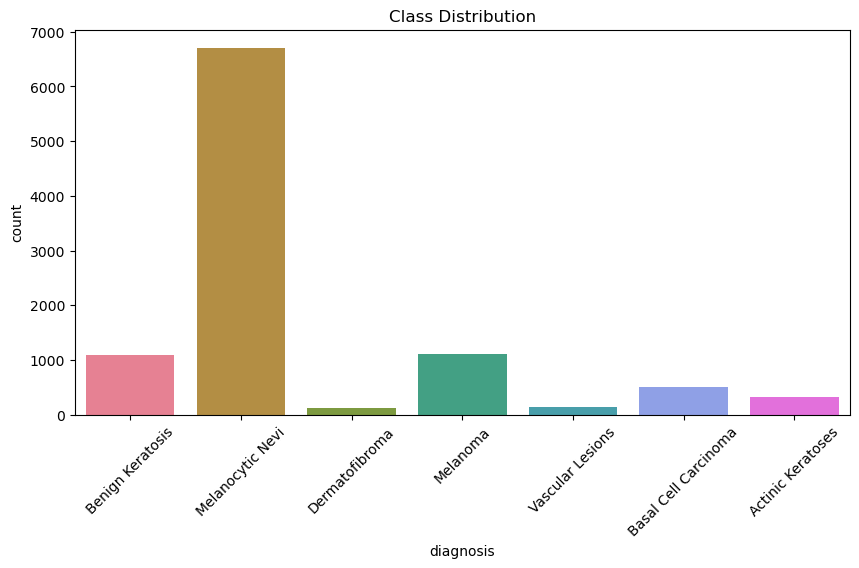

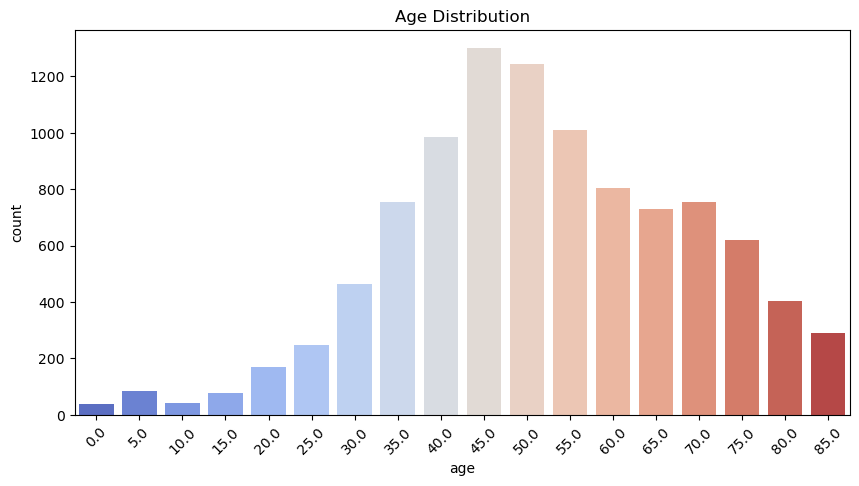

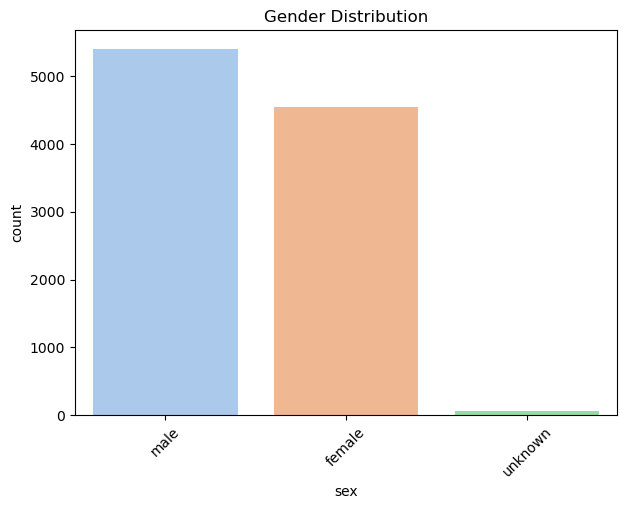

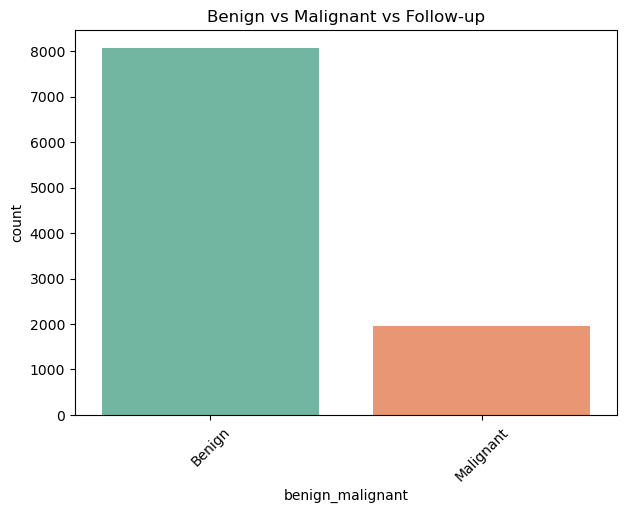

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define class mapping
class_mapping = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

metadata["diagnosis"] = metadata["dx"].map(class_mapping)
metadata["age"].fillna(metadata["age"].median(), inplace=True)
metadata["sex"].fillna("Unknown", inplace=True)
metadata["dx"].fillna("Unknown", inplace=True)

# Define function to categorize cases
def categorize_case(dx):
    return "Benign" if dx in ['nv', 'bkl', 'df', 'vasc'] else "Malignant" if dx in ['mel', 'bcc', 'akiec'] else "Follow-up"

metadata["benign_malignant"] = metadata["dx"].apply(categorize_case)

# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(x=metadata["diagnosis"], palette="husl")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x=metadata['age'], palette="coolwarm")
plt.title("Age Distribution")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(x=metadata['sex'], palette="pastel")
plt.title("Gender Distribution")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(x=metadata["benign_malignant"], palette="Set2")
plt.title("Benign vs Malignant vs Follow-up")
plt.xticks(rotation=45)
plt.show()

In [3]:
#Print the amount of images and the amount of labels
print(f"Total number of images: {len(metadata)}")
print(f"Unique labels: {metadata['diagnosis'].nunique()}")

Total number of images: 10015
Unique labels: 7


Diagnosis types: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


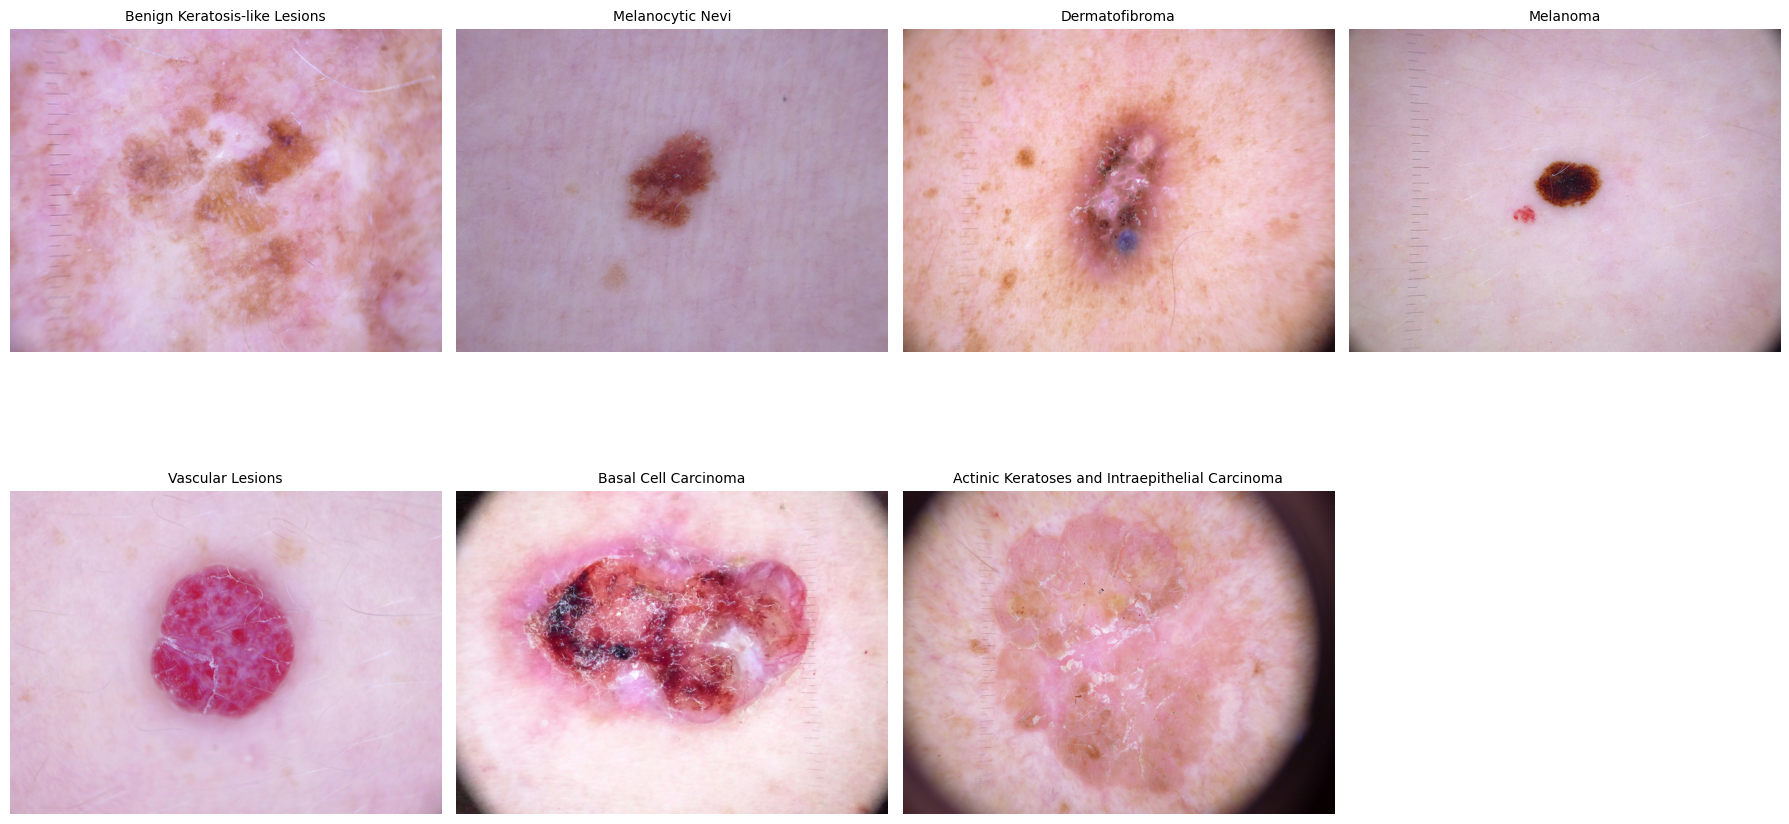

In [4]:
# Mapping abbreviations to full names
label_dict = {
    "akiec": "Actinic Keratoses and Intraepithelial Carcinoma",
    "bcc": "Basal Cell Carcinoma",
    "bkl": "Benign Keratosis-like Lesions",
    "df": "Dermatofibroma",
    "mel": "Melanoma",
    "nv": "Melanocytic Nevi",
    "vasc": "Vascular Lesions"
}

# Get unique diagnosis types
diagnosis_types = metadata["dx"].unique()
print("Diagnosis types:", diagnosis_types)

# Set up plot
plt.figure(figsize=(18, 10))

# Loop through each diagnosis and plot one sample image
for i, diag in enumerate(diagnosis_types):
    sample_row = metadata[metadata["dx"] == diag].iloc[0]
    image = cv2.imread(sample_row["image_path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plotting
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(label_dict[diag], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# Function to get image shape
def get_image_shape(image_path):
    if image_path:
        image = cv2.imread(image_path)
        if image is not None:
            return image.shape  # returns (height, width, channels)
    return None

# Apply function to get image sizes
metadata["image_size"] = metadata["image_path"].apply(get_image_shape)

# Display first few entries to verify
print(metadata[["image_id", "dx", "image_size"]].head())


       image_id   dx     image_size
0  ISIC_0027419  bkl  (450, 600, 3)
1  ISIC_0025030  bkl  (450, 600, 3)
2  ISIC_0026769  bkl  (450, 600, 3)
3  ISIC_0025661  bkl  (450, 600, 3)
4  ISIC_0031633  bkl  (450, 600, 3)


In [6]:
# Count unique image sizes
image_size_counts = metadata["image_size"].value_counts()
print("Unique image sizes and their counts:\n")
print(image_size_counts)


Unique image sizes and their counts:

image_size
(450, 600, 3)    10015
Name: count, dtype: int64


Pre-Processing - Resizing

In [7]:
# Define target size
TARGET_SIZE = (224, 224)

# List to store resized image arrays
resized_image_array = []

# Loop through each image path and resize
for path in metadata["image_path"]:
    if path:
        image = cv2.imread(path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(image, TARGET_SIZE)
            resized_image_array.append(resized)
        else:
            resized_image_array.append(None)  # in case reading fails
    else:
        resized_image_array.append(None)  # in case path is missing

# Optional: Add to metadata if you want
metadata["resized"] = resized_image_array

# Verify shape of a few
for i in range(3):
    if resized_image_array[i] is not None:
        print(f"Image {i} shape: {resized_image_array[i].shape}")


Image 0 shape: (224, 224, 3)
Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)


**MODEL** - Only with handeling the class imbalances - Used Oversampling and Undersampling - Every class as a total of 1500 images making a total of 10500


Number of images per class before balancing:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


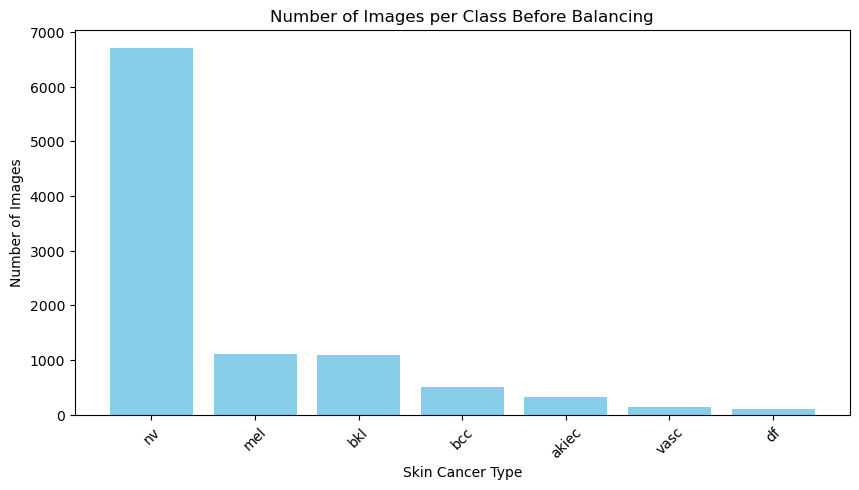


Dataset after balancing:
dx
bkl      1500
nv       1500
df       1500
mel      1500
vasc     1500
bcc      1500
akiec    1500
Name: count, dtype: int64


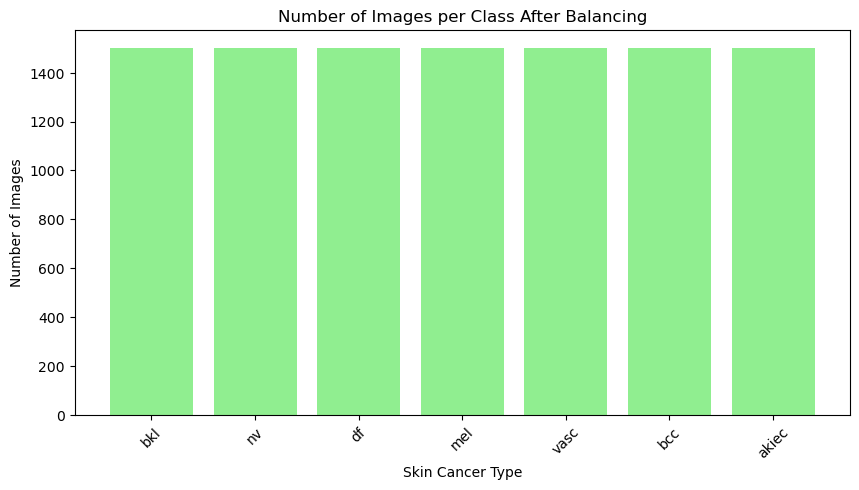

Epoch 1/20


262/262 [==============================] - 150s 560ms/step - loss: 1.4187 - accuracy: 0.4371 - val_loss: 1.0369 - val_accuracy: 0.5909
Epoch 2/20
262/262 [==============================] - 144s 552ms/step - loss: 1.0773 - accuracy: 0.5851 - val_loss: 0.9336 - val_accuracy: 0.6375
Epoch 3/20
262/262 [==============================] - 134s 511ms/step - loss: 0.9379 - accuracy: 0.6404 - val_loss: 0.8648 - val_accuracy: 0.6716
Epoch 4/20
262/262 [==============================] - 123s 470ms/step - loss: 0.8610 - accuracy: 0.6726 - val_loss: 0.8427 - val_accuracy: 0.6649
Epoch 5/20
262/262 [==============================] - 126s 481ms/step - loss: 0.7567 - accuracy: 0.7146 - val_loss: 0.7486 - val_accuracy: 0.7053
Epoch 6/20
262/262 [==============================] - 118s 453ms/step - loss: 0.6784 - accuracy: 0.7513 - val_loss: 0.6410 - val_accuracy: 0.7433
Epoch 7/20
262/262 [==============================] - 149s 569ms/step - loss: 0.6242 - accuracy: 0.7706 - val_loss: 0.5984

In [9]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

# ----------------------------
# 1. Preprocessing Tabular Data
# ----------------------------
# Assume 'metadata' is your DataFrame with columns: 'image_path', 'dx', 'age', 'sex', 'localization'
# Fill missing values for tabular data
metadata['age'] = metadata['age'].fillna(metadata['age'].median())
metadata['sex'] = metadata['sex'].fillna('unknown')
metadata['localization'] = metadata['localization'].fillna('unknown')

# Scale the numeric column (age)
scaler = StandardScaler()
metadata['age_scaled'] = scaler.fit_transform(metadata[['age']])

# One-hot encode categorical features: sex and localization
sex_encoder = OneHotEncoder(sparse_output=False)
local_encoder = OneHotEncoder(sparse_output=False)

sex_ohe = sex_encoder.fit_transform(metadata[['sex']])
local_ohe = local_encoder.fit_transform(metadata[['localization']])

# Combine the tabular features: [age_scaled, sex_onehot, localization_onehot]
tabular_features = np.concatenate([metadata[['age_scaled']].values, sex_ohe, local_ohe], axis=1)
metadata['tabular_features'] = list(tabular_features)

# Determine the dimension of the tabular data
tab_data_dim = tabular_features.shape[1]


# ----------------------------
# 2. Handle Class Balancing with Oversampling (with Rotation Augmentation)
# ----------------------------

# Set the target number of images per class
class_limits = 1500

# List to store the DataFrame for each class after balancing
balanced_metadata_list = []

# Create a directory to save augmented images if it doesn't exist
augmented_dir = "augmented_images"
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

def rotate_image(image, angle):
    """
    Rotate the input image by the given angle.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    # Get the rotation matrix and perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# Process each skin cancer class in the metadata
for label in metadata['dx'].unique():
    class_data = metadata[metadata['dx'] == label]
    count = len(class_data)
    
    # If there are more than class_limits images, sample down to class_limits
    if count > class_limits:
        class_data = class_data.sample(class_limits, random_state=42)
    
    # If there are fewer images than class_limits, oversample with augmentation
    elif count < class_limits:
        # Start with the existing images for the class
        oversampled_data = class_data.copy()
        missing_count = class_limits - count
        
        for i in range(missing_count):
            # Randomly select one row for augmentation
            sample_row = class_data.sample(n=1, random_state=42+i).iloc[0]
            img_path = sample_row['image_path']
            
            # Load the image using cv2
            img = cv2.imread(img_path)
            if img is None:
                print("Warning: Could not load image", img_path)
                continue
            
            # Choose a random rotation angle from a set of options
            angle = random.choice([-15, -10, -5, 5, 10, 15])
            aug_img = rotate_image(img, angle)
            
            # Generate a new filename for the augmented image
            base_name = os.path.basename(img_path)
            new_file_name = os.path.splitext(base_name)[0] + f"_aug_{i}.jpg"
            new_path = os.path.join(augmented_dir, new_file_name)
            
            # Save the augmented image
            cv2.imwrite(new_path, aug_img)
            
            # Create a new row for the augmented image by copying the original row and updating the path
            new_row = sample_row.copy()
            new_row['image_path'] = new_path
            
            # Use pd.concat to add the new row, converting the new_row to a DataFrame first
            oversampled_data = pd.concat([oversampled_data, pd.DataFrame([new_row])], ignore_index=True)
        
        # Now the class_data has class_limits images (original + augmented)
        class_data = oversampled_data
    
    balanced_metadata_list.append(class_data)


# Concatenate the balanced data from each class into one DataFrame
balanced_metadata = pd.concat(balanced_metadata_list, ignore_index=True)
balanced_metadata = balanced_metadata.reset_index(drop=True)

# ----------------------------
# 3. Display the Dataset Distribution Before and After Balancing
# ----------------------------

# Plot and print the distribution before balancing
print("\nNumber of images per class before balancing:")
print(metadata['dx'].value_counts())

plt.figure(figsize=(10, 5))
plt.bar(metadata['dx'].value_counts().index, metadata['dx'].value_counts(), color='skyblue')
plt.title('Number of Images per Class Before Balancing')
plt.xlabel('Skin Cancer Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Print and plot the distribution after balancing
print("\nDataset after balancing:")
print(balanced_metadata['dx'].value_counts())

plt.figure(figsize=(10, 5))
plt.bar(balanced_metadata['dx'].value_counts().index, balanced_metadata['dx'].value_counts(), color='lightgreen')
plt.title('Number of Images per Class After Balancing')
plt.xlabel('Skin Cancer Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# ----------------------------
# 4. Encode Labels (using LabelEncoder)
# ----------------------------

le = LabelEncoder()
balanced_metadata['label_encoded'] = le.fit_transform(balanced_metadata['dx'])
num_classes = len(le.classes_)

# ----------------------------
# 4. Train/Validation Split
# ----------------------------

train_df, val_df = train_test_split(balanced_metadata, test_size=0.2, 
                                      stratify=balanced_metadata['label_encoded'], 
                                      random_state=42)

# ----------------------------
# 5. Create a Custom Data Generator
# ----------------------------
def data_generator(df, batch_size):
    df = df.reset_index(drop=True)
    while True:
        # Shuffle the DataFrame at the start of each epoch
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i+batch_size]
            images = []
            tab_data = []
            labels = []
            for _, row in batch.iterrows():
                # Load and preprocess image
                img = cv2.imread(row['image_path'])
                if img is None:
                    continue  # skip if the image cannot be read
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                images.append(img)
                # Get the precomputed tabular features
                tab_data.append(row['tabular_features'])
                # Label (already encoded)
                labels.append(row['label_encoded'])
            if len(images) == 0:
                continue
            images = np.array(images, dtype='float32')
            tab_data = np.array(tab_data, dtype='float32')
            labels = np.array(labels, dtype='int32')
            yield {"image_input": images, "tabular_input": tab_data}, labels

batch_size = 32
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

# ----------------------------
# 6. Build the Multi-Input Model
# ----------------------------

# Define the image branch of the model
image_input = Input(shape=(224, 224, 3), name='image_input')
x = tf.keras.layers.Rescaling(1./255)(image_input)
# First Convolutional Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
# Second Convolutional Layer
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
# Third Convolutional Layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Define the tabular branch of the model
# 'tab_data_dim' should be defined as the number of tabular features you are using.
tab_data_dim = tabular_features.shape[1] # Change the 19 to the tabular_features_shape[1] later, because the metadata only has 7 columns. 
tabular_input = Input(shape=(tab_data_dim,), name='tabular_input')
y = Dense(32, activation='relu')(tabular_input)
y = Dense(16, activation='relu')(y)

# Combine the branches
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(num_classes, activation='softmax')(z)

# Create and compile the model
model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ----------------------------
# 7. Train the Model
# ----------------------------

batch_size = 32
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

# Note: data_generator is assumed to be your custom generator that reads images from 'image_path'
history = model.fit(
    data_generator(train_df, batch_size),  # Custom data generator
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=data_generator(val_df, batch_size),  # Custom data generator for validation
    validation_steps=val_steps
)


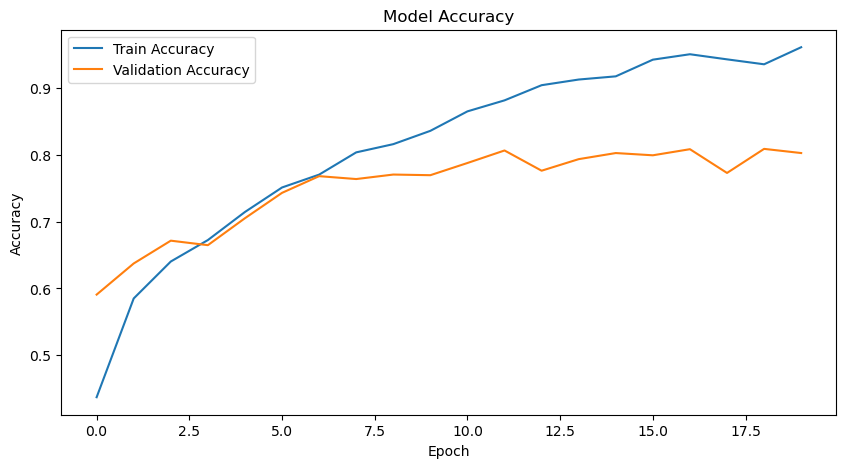

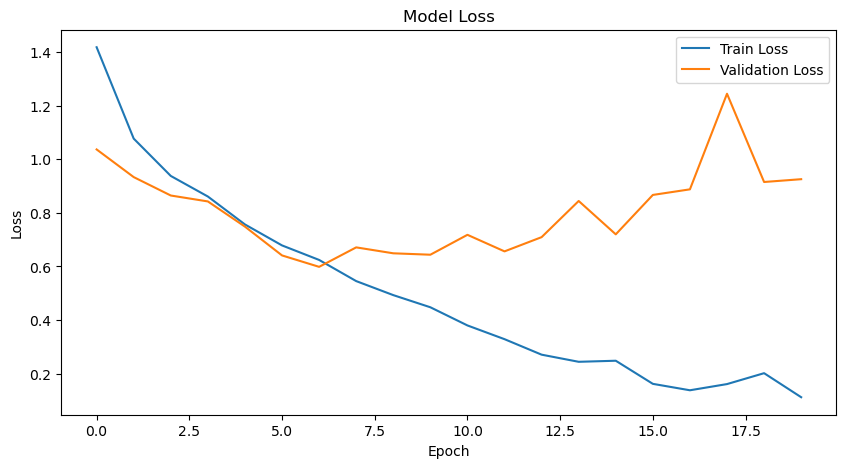

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 190ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.78      0.88      0.82       300
         bcc       0.77      0.82      0.80       300
         bkl       0.62      0.64      0.63       300
          df       0.96      1.00      0.98       300
         mel       0.68      0.57      0.62       300
          nv       0.81      0.71      0.76       300
        vasc       0.98      1.00      0.99       300

    accuracy                           0.80      2100
   macro avg       0.80      0.80      0.80      2100
weighted avg       0.80      0.80      0.80      2100



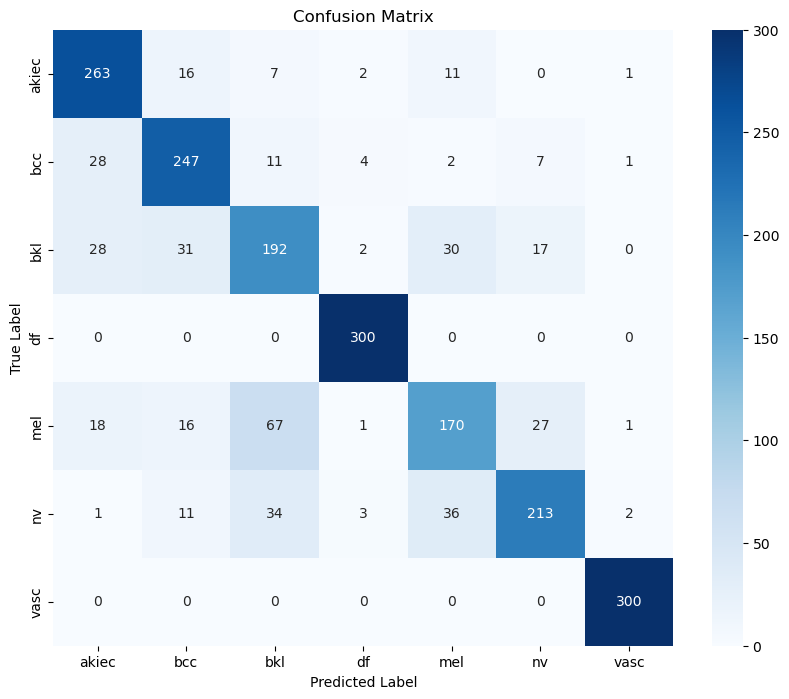

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions on the validation set
# Here, we use the data_generator for validation data.

y_true = []
y_pred = []

# We assume 'data_generator' is a generator that outputs batches as a tuple: ([images, tabular_data], labels).
# Also ensure that the generator does not shuffle the data.
val_steps = len(val_df) // batch_size + 1  # +1 to include any last incomplete batch

for i, (inputs, labels) in enumerate(data_generator(val_df, batch_size)):
    preds = model.predict(inputs)
    y_true.extend(labels)
    y_pred.extend(np.argmax(preds, axis=1))
    if i >= val_steps - 1:
        break

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optionally, print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ----------------------------
# 7. Save the Model
# ----------------------------
model.save('skin_cancer_model.h5')


In [23]:
# Save the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

Prediction of a random image using the Model

In [22]:
model.get_layer(last_conv_layer_name)

True Label (from filename): example
1/1 [==============================] - 0s 49ms/step
Predicted Label: Basal Cell Carcinoma
Model Confidence: 98.90%


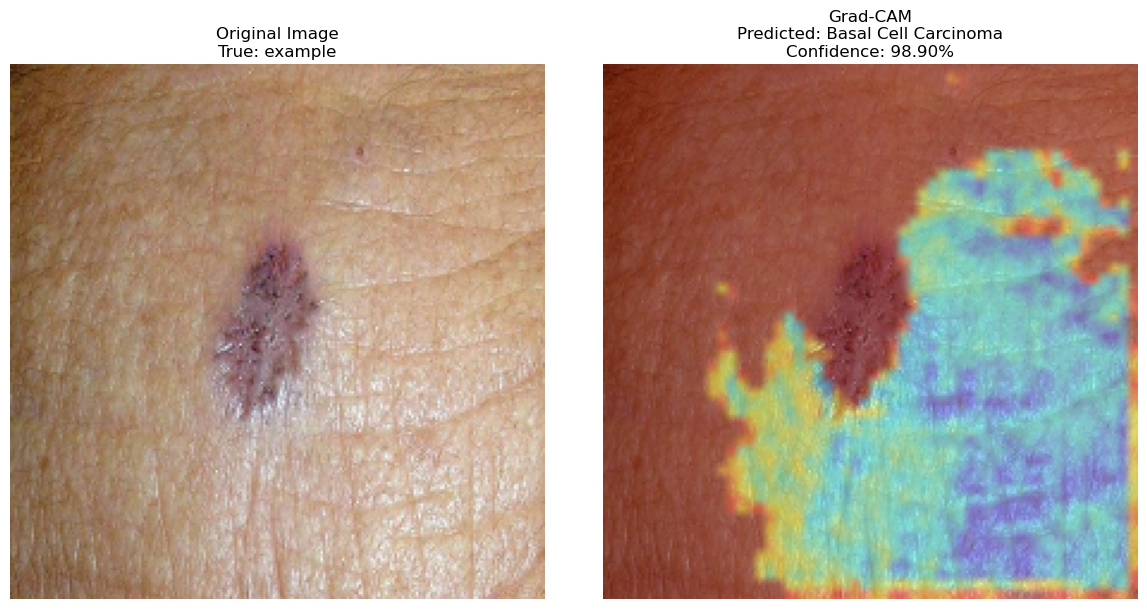

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the class mapping dictionary.
class_mapping = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

# ------------- 1. Set the image file path --------------------
# Replace with the path to your image.
image_file = "example_4.jpg"  # Example filename: "mel_123.jpg"

# ------------- 2. Extract the true label from the filename --------------------
# This example assumes that the file is named as "<short_label>_XXX.jpg"
file_base = os.path.basename(image_file)
true_label_short = file_base.split('_')[0]  # E.g., "mel"
# Map the short label to the full label name using class_mapping.
true_label_full = class_mapping.get(true_label_short, true_label_short)
print("True Label (from filename):", true_label_full)

# ------------- 3. Load and preprocess the image ---------------
# Load the image using OpenCV.
img = cv2.imread(image_file)
if img is None:
    raise ValueError(f"Could not load image: {image_file}")

# Resize the image to the model's expected input size (e.g., 224x224).
img_resized = cv2.resize(img, (224, 224))

# Convert the image from BGR (OpenCV format) to RGB (for display).
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Expand dimensions to create a batch of size 1.
img_input = np.expand_dims(img_resized, axis=0)

# ------------- 4. Prepare the tabular input ---------------------
# If you have actual tabular features for this image, replace the dummy vector below.
tab_data_dim = tabular_features.shape[1]  # Number of tabular features
tab_input = np.zeros((1, tab_data_dim), dtype=np.float32)

# ------------- 5. Make prediction with the model ----------------
# Ensure that your model and label encoder (le) are already defined/loaded.
preds = model.predict([img_input, tab_input])
predicted_index = np.argmax(preds[0])
# Retrieve the confidence (probability) for the predicted class.
confidence_percentage = preds[0][predicted_index] * 100

# The label encoder returns the short label code.
predicted_label_short = le.inverse_transform([predicted_index])[0]
# Map the predicted short label to the full label name.
predicted_label_full = class_mapping.get(predicted_label_short, predicted_label_short)

print("Predicted Label:", predicted_label_full)
print(f"Model Confidence: {confidence_percentage:.2f}%")

# ------------- 6. Define helper functions for Grad-CAM --------------
def get_gradcam_heatmap(img_array, tab_array, model, last_conv_layer_name, pred_index=None):
    """
    Computes the Grad-CAM heatmap for a given image and tabular input.
    """
    # Create a sub-model that outputs the feature maps of the specified conv layer and model predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array, tab_array])
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        # Obtain the score for the predicted class.
        loss = predictions[:, pred_index]
    
    # Compute gradients of the loss with respect to the convolutional layer's outputs.
    grads = tape.gradient(loss, conv_outputs)
    # Average the gradients spatially.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]  # [H, W, Channels]
    # Weight the feature map channels by the pooled gradients.
    heatmap = conv_outputs @ tf.expand_dims(pooled_grads, axis=-1)
    heatmap = tf.squeeze(heatmap)
    
    # Apply a ReLU to focus on the features that have a positive influence.
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        max_val = tf.constant(1e-10)
    heatmap /= max_val
    return heatmap.numpy()

def superimpose_heatmap(original_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Superimposes the Grad-CAM heatmap onto the original image.
    """
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)
    # Resize heatmap to match original image dimensions.
    heatmap_color = cv2.resize(heatmap_color, (original_img.shape[1], original_img.shape[0]))
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# ------------- 7. Compute Grad-CAM ----------------
# Choose the appropriate last convolutional layer from your model.
# Use model.summary() to verify the available layer names; here we assume "conv2d_35" is the target.
last_conv_layer_name = "conv2d_5"
heatmap = get_gradcam_heatmap(img_input, tab_input, model, last_conv_layer_name, pred_index=predicted_index)

# ------------- 8. Superimpose the heatmap on the original image -----------
superimposed_img = superimpose_heatmap(img_rgb, heatmap, alpha=0.4)

# ------------- 9. Display the results ---------------------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title(f"Original Image\nTrue: {true_label_full}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM\nPredicted: {predicted_label_full}\nConfidence: {confidence_percentage:.2f}%")
plt.axis("off")

plt.tight_layout()
plt.show()
